# V-10 flight simulation
This notebook is being developed by the avionics and flight dynamics sub-teams in The Rocket Launchers student organization at the University of Texas Rio Grande Valley. Our rocket's name is V-10 in celebration of our club's 10th anniversary! V-10 will be competing in the 10k COTS division at IREC. 

Key features of V-10:
- Air brakes
- vonKarman Nose Cone
- Replaceable fins


In [35]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, TrapezoidalFins, EllipticalFins, RailButtons, NoseCone, Tail, Parachute
import datetime 


## Environment


In [36]:
env = Environment()
env.set_location(latitude=28.61, longitude=-80.6)
env.set_elevation(1402.0800000000002)


Optionally, you can set the date and atmospheric model


In [37]:
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))
# env.set_atmospheric_model(type='Forecast', file='GFS')


Gravity Details

Acceleration of gravity at surface level:    9.7760 m/s²
Acceleration of gravity at  80.000 km (ASL): 9.5379 m/s²


Launch Site Details

Launch Date: 2025-10-29 12:00:00 UTC
Launch Site Latitude: 28.61000°
Launch Site Longitude: -80.60000°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 166021.44 W|E    0.00 N
Launch Site UTM zone: 31N
Launch Site Surface Elevation: 1402.1 m


Atmospheric Model Details

Atmospheric Model Type: standard_atmosphere
standard_atmosphere Maximum Height: 80.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 855.75 hPa
Surface Temperature: 279.05 K
Surface Air Density: 1.068 kg/m³
Surface Speed of Sound: 334.54 m/s


Earth Model Details

Earth Radius at Launch site: 6378.14 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034



Gravity Model Plots


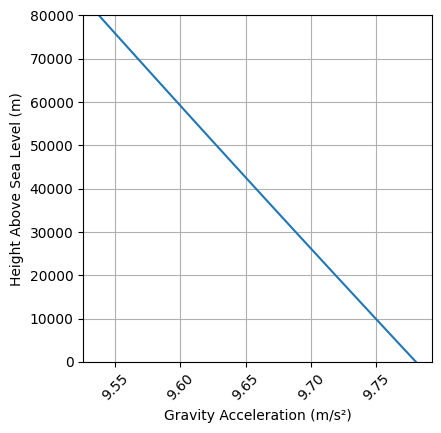



Atmospheric Model Plots


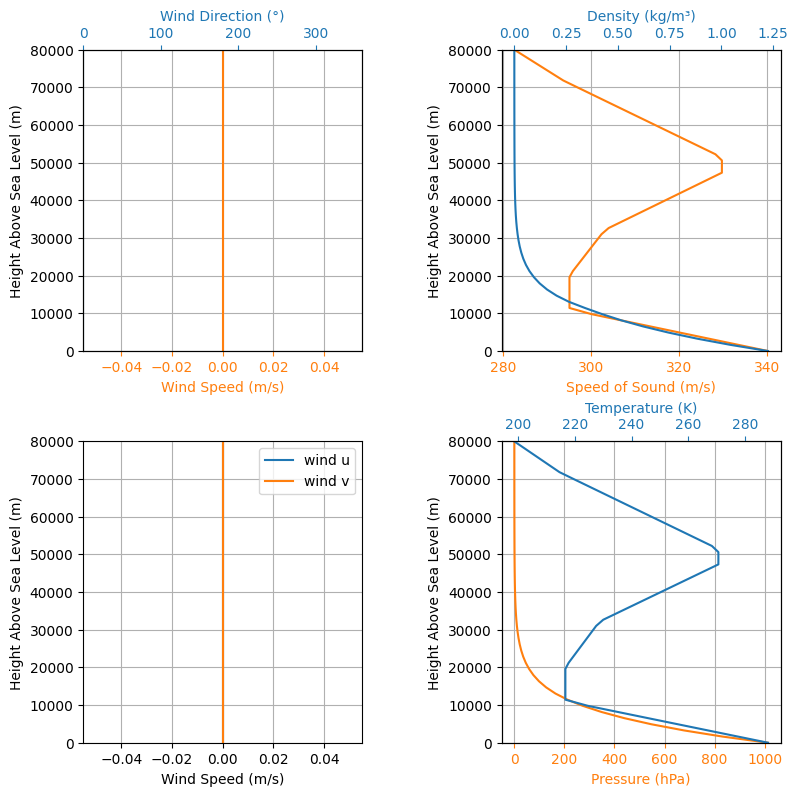

In [38]:
env.all_info()


## Motor
V-10 uses an AeroTech M2500T (98 mm) solid motor. We load the thrust curve from the local ENG file and set geometry and masses as follows:

- Diameter: 98 mm (outer grain radius 0.049 m)
- Grain length used: 0.732 m
- Propellant mass: 4.711 kg
- Total motor mass: 8.064 kg → Dry mass used: 3.353 kg
- Average thrust: ~2,500 N; Max thrust: ~3,711–4,081 N; Total impulse: ~9,671 Ns
- Nozzle radius: 0.03675 m; Throat radius: 0.0245 m
- Orientation: nozzle_to_combustion_chamber

These values are reflected directly in the code below.

In [39]:
m2500t = SolidMotor(
    thrust_source='/Users/luis/Projects/Python/RL-RocketPy-Notebook/data/AeroTech_M2500T.eng',
    dry_mass=3.353,  # Total 8.064 kg - Propellant 4.711 kg per cell 8
    center_of_dry_mass_position=0,
    dry_inertia=[0, 0, 0],
    grains_center_of_mass_position=0,
    grain_number=1,
    # Set density to match 4.711 kg propellant mass given geometry
    grain_density=1137.5,
    grain_outer_radius=0.049,  # 98 mm diameter
    grain_initial_inner_radius=0.0245,
    grain_initial_height=0.732,  # Length per cell 8
    grain_separation=0,
    nozzle_radius=0.036750000000000005,
    nozzle_position=-0.351,
    throat_radius=0.0245,
    reshape_thrust_curve=False,  # Not implemented in Rocket-Serializer
    interpolation_method='linear',
    coordinate_system_orientation='nozzle_to_combustion_chamber',
)

Nozzle Details
Nozzle Radius: 0.036750000000000005 m
Nozzle Throat Radius: 0.0245 m

Grain Details
Number of Grains: 1
Grain Spacing: 0 m
Grain Density: 1137.5 kg/m3
Grain Outer Radius: 0.049 m
Grain Inner Radius: 0.0245 m
Grain Height: 0.732 m
Grain Volume: 0.004 m3
Grain Mass: 4.710 kg

Motor Details
Total Burning Time: 3.9021 s
Total Propellant Mass: 4.710 kg
Structural Mass Ratio: 0.416
Average Propellant Exhaust Velocity: 1922.523 m/s
Average Thrust: 2320.807 N
Maximum Thrust: 4080.53093197668 N at 2.40567201759911 s after ignition.
Total Impulse: 9056.021 Ns



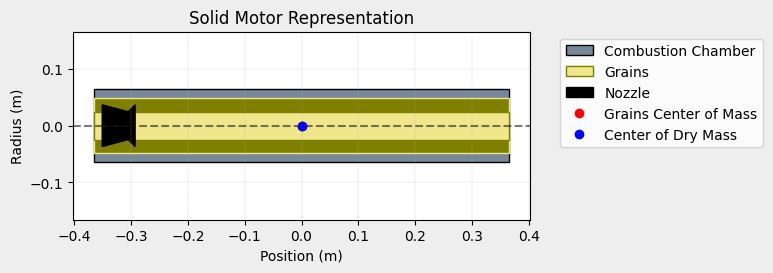

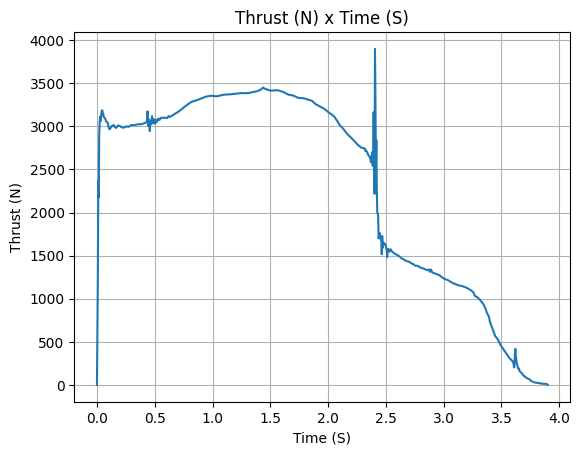

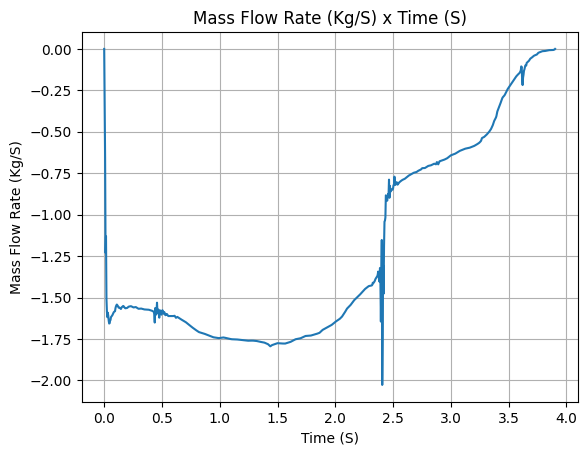

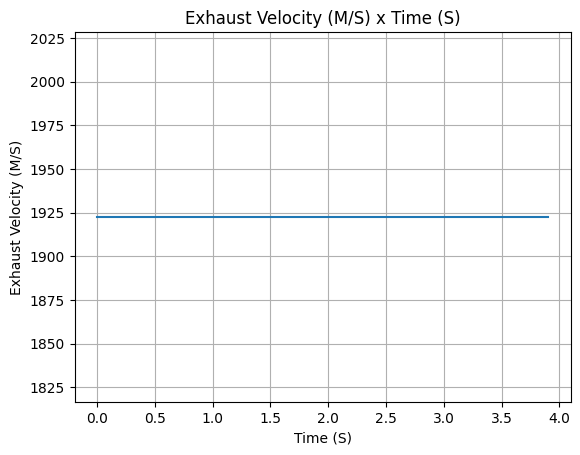

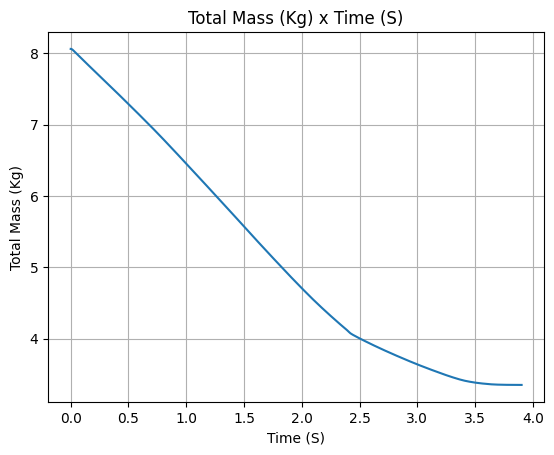

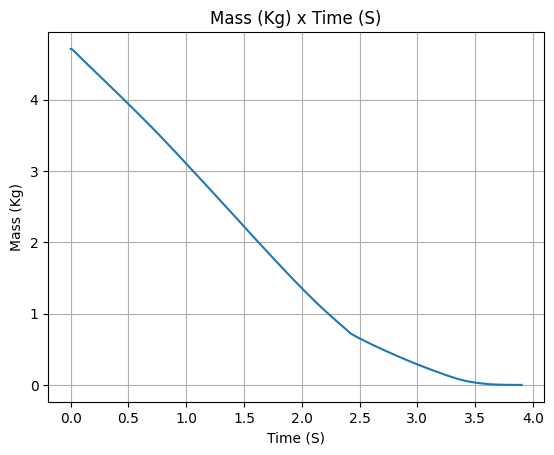

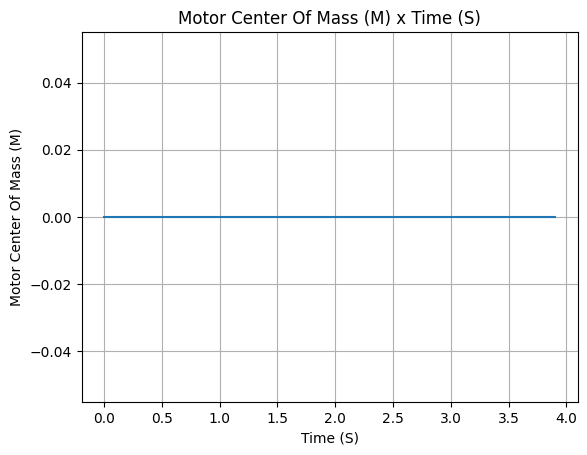

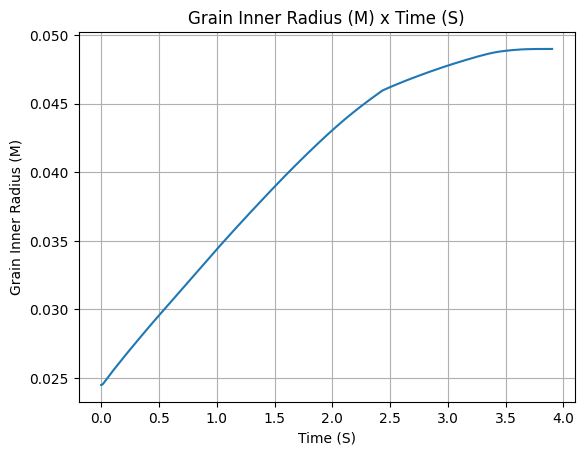

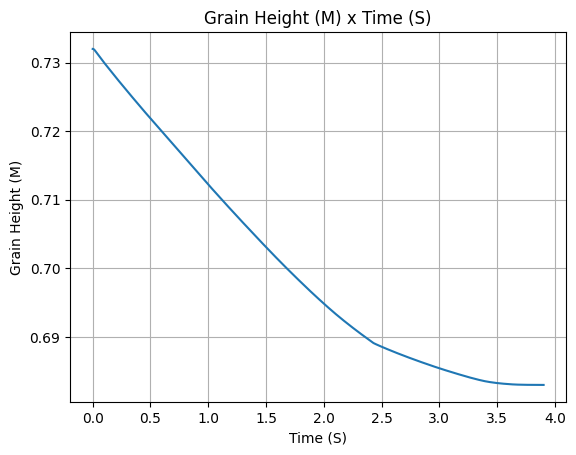

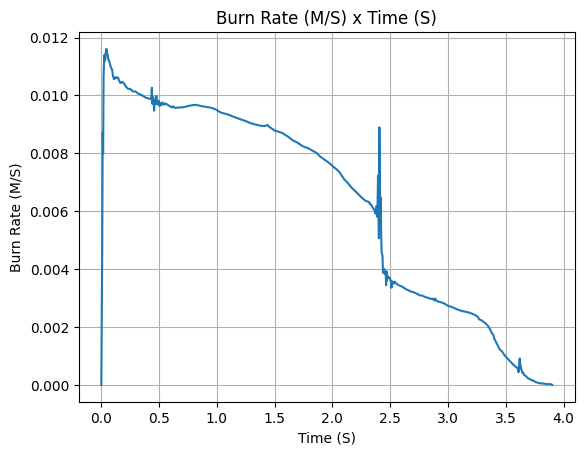

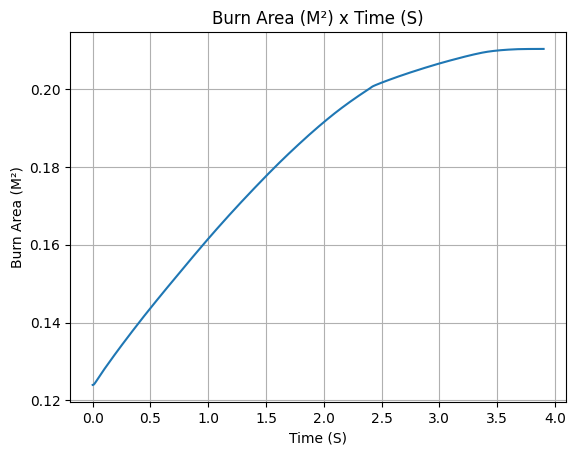

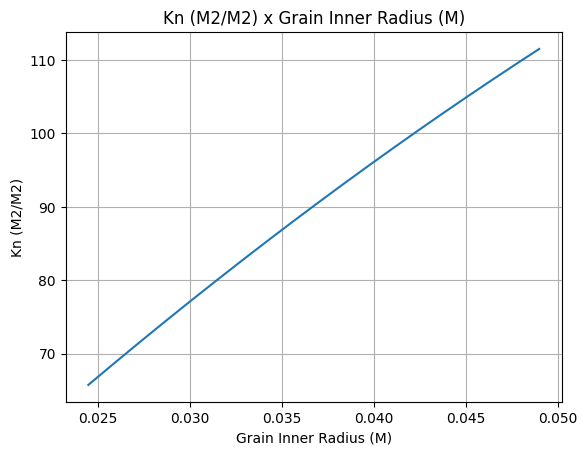

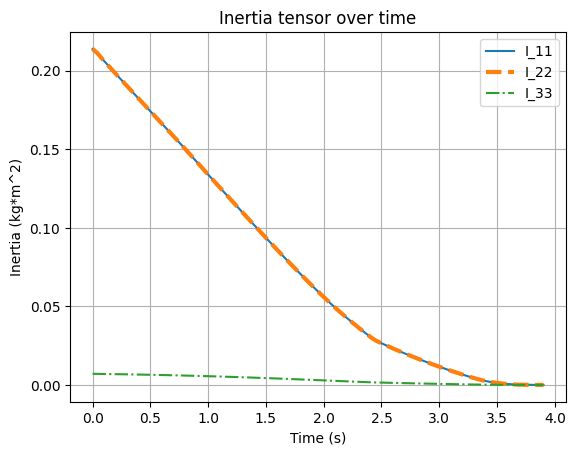

In [40]:
m2500t.all_info()


## Rocket
V-10 is a single-stage rocket. We first define aerodynamic surfaces, then assemble the rocket with mass/inertia and drag models.

- Reference radius: 0.0777875 m
- Dry mass (without motor): 28.271 kg
- Center of mass (without motor): 1.476 m from nose tip
- Inertia tensor (about body axes): [0.115, 0.115, 21.424] kg·m²
- Coordinate system orientation: nose_to_tail

Next, we create surfaces (nose cone, fins, boat tail) and then build the rocket object with the above properties.

### Nose cone
V-10 uses a Haack (Von Kármán equivalent) nose cone with:
- Length: 0.381 m
- Base radius: 0.0777875 m

We'll use RocketPy's Von Karman nose cone with these dimensions.

In [41]:
nosecone = NoseCone(
    length=0.381,
    kind='Von Karman',
    base_radius=0.0777875,
    rocket_radius=0.0777875,
    name='Nose Cone',
)


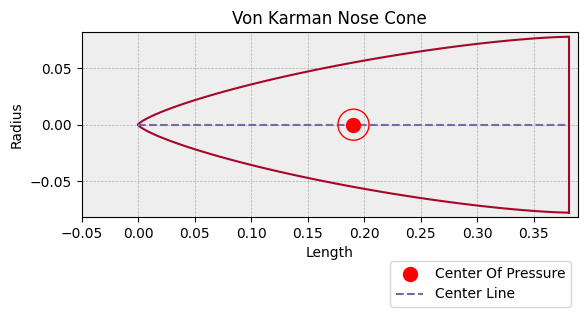

In [42]:
nosecone.draw()

### Fins
Using dimensions from the V-10 design, we approximate the freeform fin set as trapezoidal fins:

- Count: 4 fins
- Root chord: 0.3048 m
- Tip chord: 0.01905 m (based on planform points)
- Span: 0.1524 m
- Leading-edge sweep length: 0.254 m

These values match the fin planform used for V-10.

In [43]:
fins = TrapezoidalFins(
    n=4,
    root_chord=0.3048,
    tip_chord=0.01905,
    span=0.1524,
    sweep_length=0.254,
    rocket_radius=0.0777875,
    name="CF Trapezoidal (approx from V-10)",
)

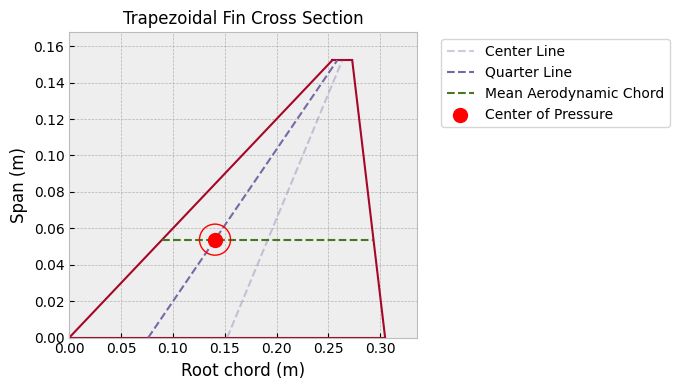

In [44]:
fins.draw()

### Transitions (Tails)
Boat tail per V-10:
- Shape: Conical
- Length: 0.0508 m
- Fore (top) radius: 0.0777875 m (matches body)
- Aft (bottom) radius: 0.0635 m

We'll create this as a Tail surface and add it to the rocket at the aft end.

In [45]:
tails = {}


In [46]:
tails[0] = Tail(
    top_radius=0.0777875,
    bottom_radius=0.0635,
    length=0.0508,
    rocket_radius=0.0777875,
    name='Boat Tail',
)


### Parachutes
Using the V-10 model data and converting diameter to CdS (CdS = CD × area):
- Main: CD = 2.2, Diameter = 2.7432 m → area ≈ 5.909 m² → CdS ≈ 13.0 (we use 13.003)
- Drogue: CD = 2.2, Diameter = 0.6096 m → area ≈ 0.2918 m² → CdS ≈ 0.642

We trigger the main by altitude (396.24 m) and the drogue at apogee.

In [47]:
parachutes = {}


In [48]:
parachutes[0] = Parachute(
    name='Main Parachute + Bag',
    cd_s=13.003,
    trigger=396.240,
    sampling_rate=100, 
)


In [49]:
parachutes[1] = Parachute(
    name='Drogue',
    cd_s=0.292,
    trigger='apogee',
    sampling_rate=100, 
)


In [50]:
import numpy as np

# Initial Cd vs Mach curves for V-10; tune later with flight data or CFD.
cd_power_off = np.array([
    [0.00, 0.45],
    [0.50, 0.50],
    [0.90, 0.55],
    [1.00, 0.75],
    [1.20, 0.65],
    [2.00, 0.50],
    [3.00, 0.45],
])

cd_power_on = np.array([
    [0.00, 0.40],
    [0.50, 0.45],
    [0.90, 0.50],
    [1.00, 0.70],
    [1.20, 0.60],
    [2.00, 0.45],
    [3.00, 0.40],
])

rocket = Rocket(
    radius=0.0777875,
    mass=28.271,
    inertia=[0.115, 0.115, 21.424],
    power_off_drag=cd_power_off,
    power_on_drag=cd_power_on,
    center_of_mass_without_motor=1.85,
    coordinate_system_orientation='nose_to_tail',
)


### Adding surfaces to the rocket
We add:
- Nose cone at 0.0 m (tip reference)
- Fins at 1.4572 m (start of lower body tube per V-10)
- Boat tail at 2.8964 m (aft end)

Positions are measured from the nose tip following the 'nose_to_tail' convention.

In [51]:
rocket.add_surfaces(surfaces=[nosecone, fins, tails[0]], positions=[0.0, 2.54, 2.8964])

In [52]:
rocket.add_motor(m2500t, position= 2.4727773722627746)


Adding parachutes to the rocket


In [53]:
rocket.parachutes = list(parachutes.values())


### Rail Buttons
Positions derived from V-10's launch lugs (converted to distances from the nose tip and centered on lug length 0.0381 m):
- Upper button center ≈ 1.7778 m
- Lower button center ≈ 1.3906 m
- Angular position: 60°

In [54]:
rail_buttons = rocket.set_rail_buttons(
   upper_button_position=1.7778,
   lower_button_position=1.3906,
   angular_position=60.0,
)


Inertia Details

Rocket Mass: 28.271 kg (without motor)
Rocket Dry Mass: 31.624 kg (with unloaded motor)
Rocket Loaded Mass: 36.334 kg
Rocket Structural Mass Ratio: 0.870
Rocket Inertia (with unloaded motor) 11: 1.278 kg*m2
Rocket Inertia (with unloaded motor) 22: 1.278 kg*m2
Rocket Inertia (with unloaded motor) 33: 21.424 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0777875 m
Rocket Frontal Area: 0.019009 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.066 m
Rocket Center of Dry Mass - Nozzle Exit: 0.908 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.557 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.072 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
CF Trapezoidal (approx from V-10) Lift Coefficient Derivative: 8

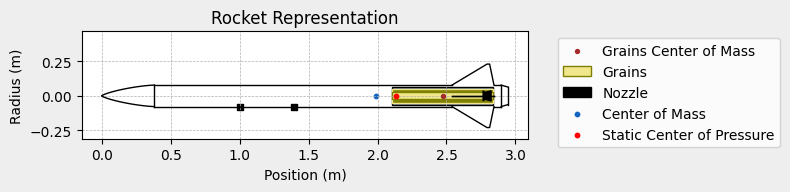


Mass Plots
----------------------------------------


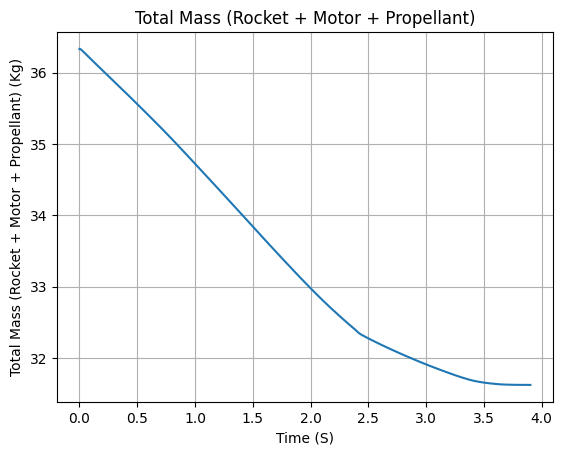

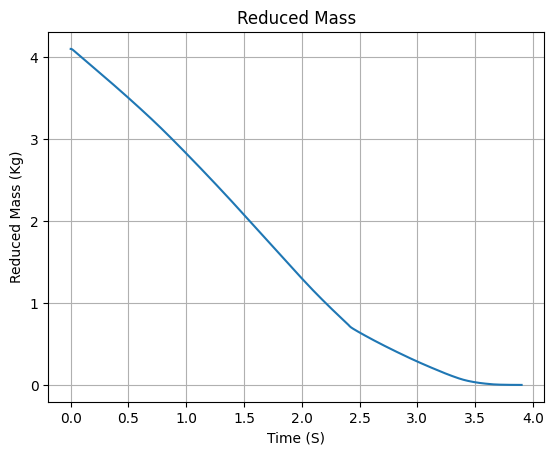


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


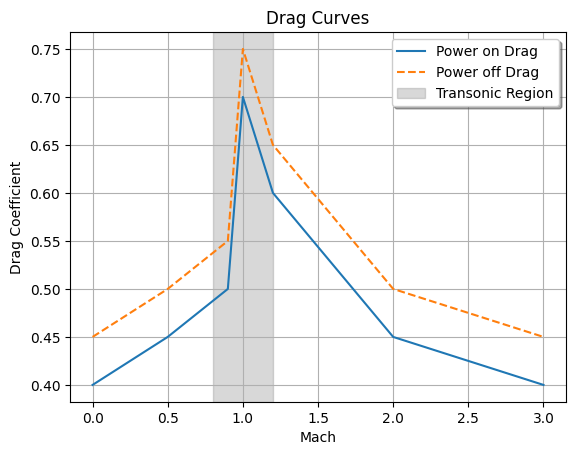


Stability Plots
--------------------


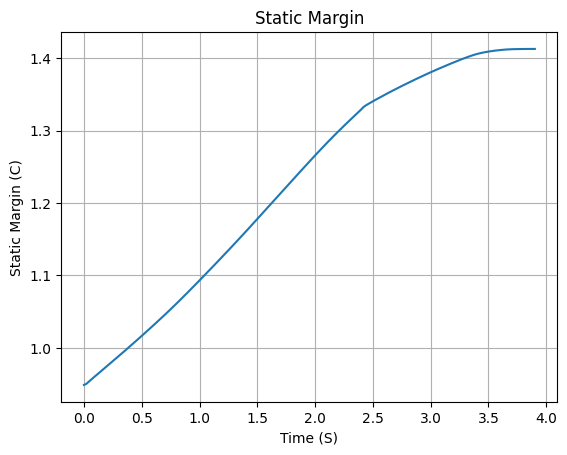

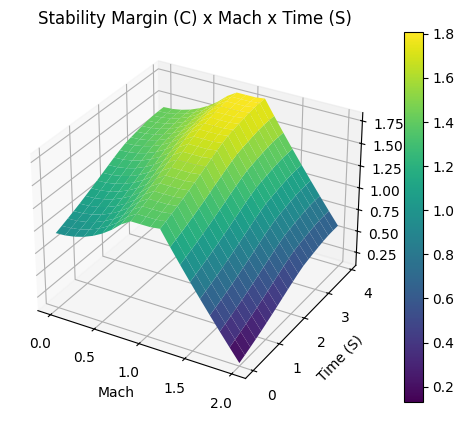


Thrust-to-Weight Plot
----------------------------------------


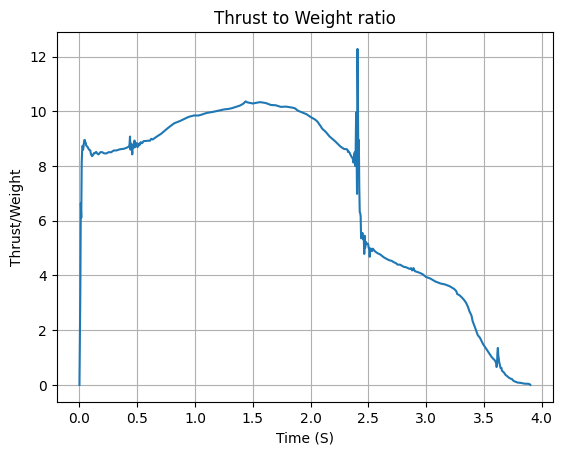

In [55]:
### Rocket Info
rocket.all_info()


## Flight
We will now create the flight simulation. Let's go!


In [56]:
flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=5.1816,
    inclination=90.0,
    heading=90.0,
    terminate_on_apogee=False,
    max_time=600,
)


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 1402.08 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: -0.259 | e1: 0.000 | e2: 0.000 | e3: 0.966
Euler Angles - Spin φ : 105.00° | Nutation θ: 0.00° | Precession ψ: 105.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 0.949 c


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 5.1816 m
Launch Rail Inclination: 90.00°
Launch Rail Heading: 90.00°


Rail Departure State

Rail Departure Time: 0.311 s
Rail Departure Velocity: 22.245 m/s
Rail Departure Stability Margin: 0.992 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 8.567
Rail Departure Reynolds Number: 2.121e+05


Burn out State

Burn out time: 3.902 s
Altitude at burn out: 1951.051 m (ASL) | 548.971 m (AGL)
Rocket speed at burn out: 215.174 m/s
Freestream 

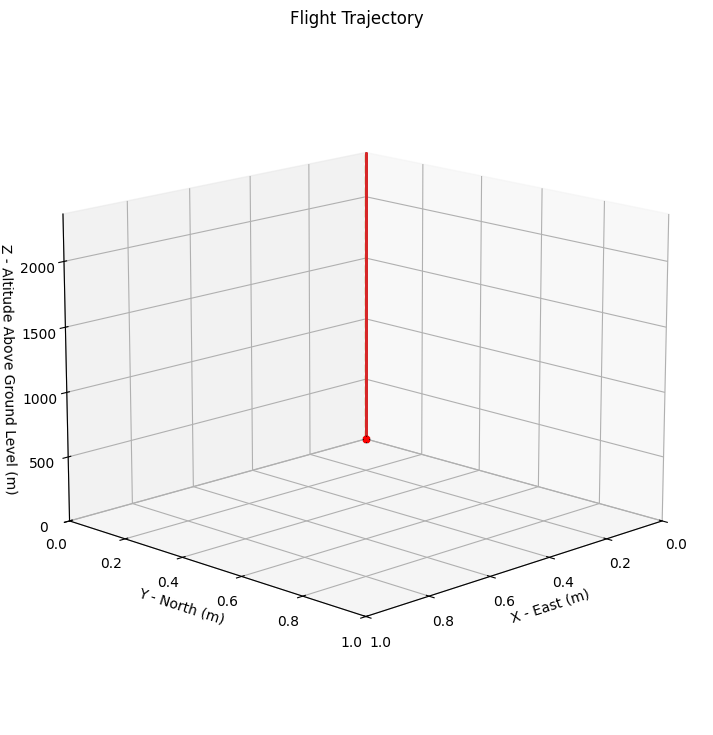



Trajectory Kinematic Plots



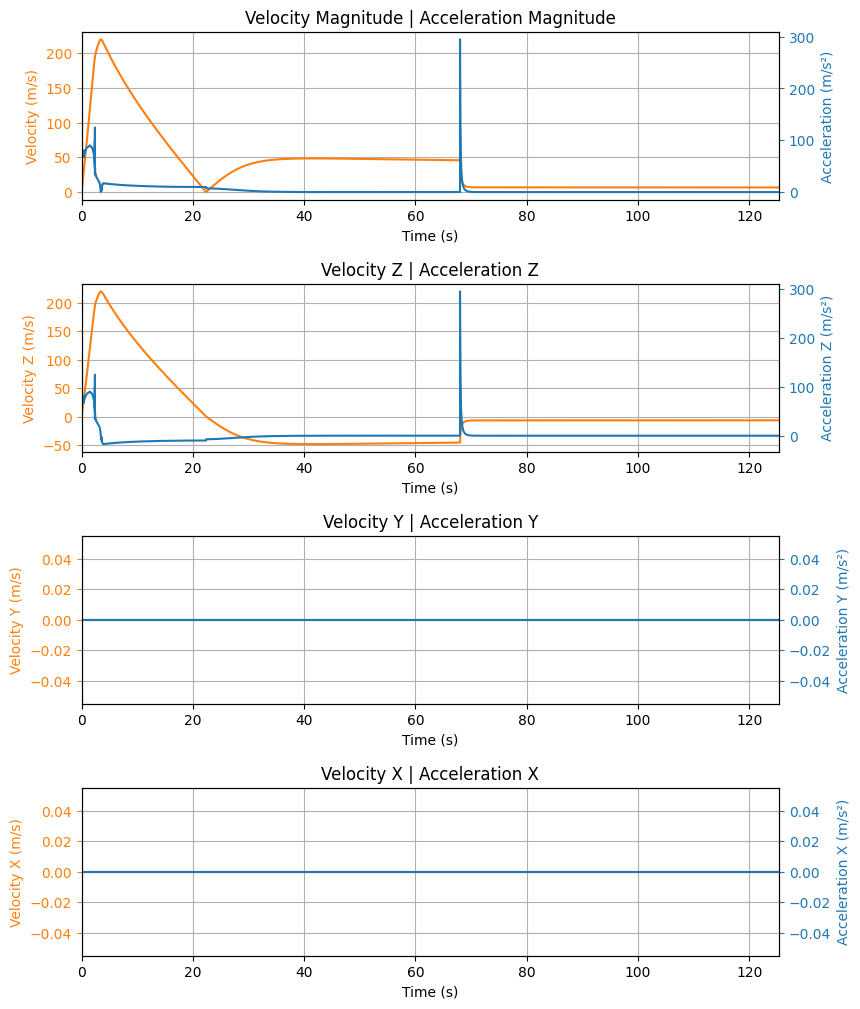



Angular Position Plots



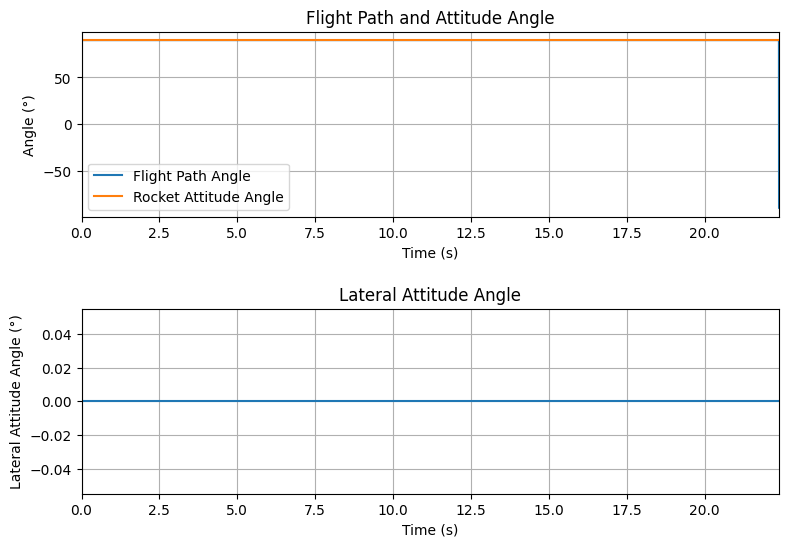



Path, Attitude and Lateral Attitude Angle plots



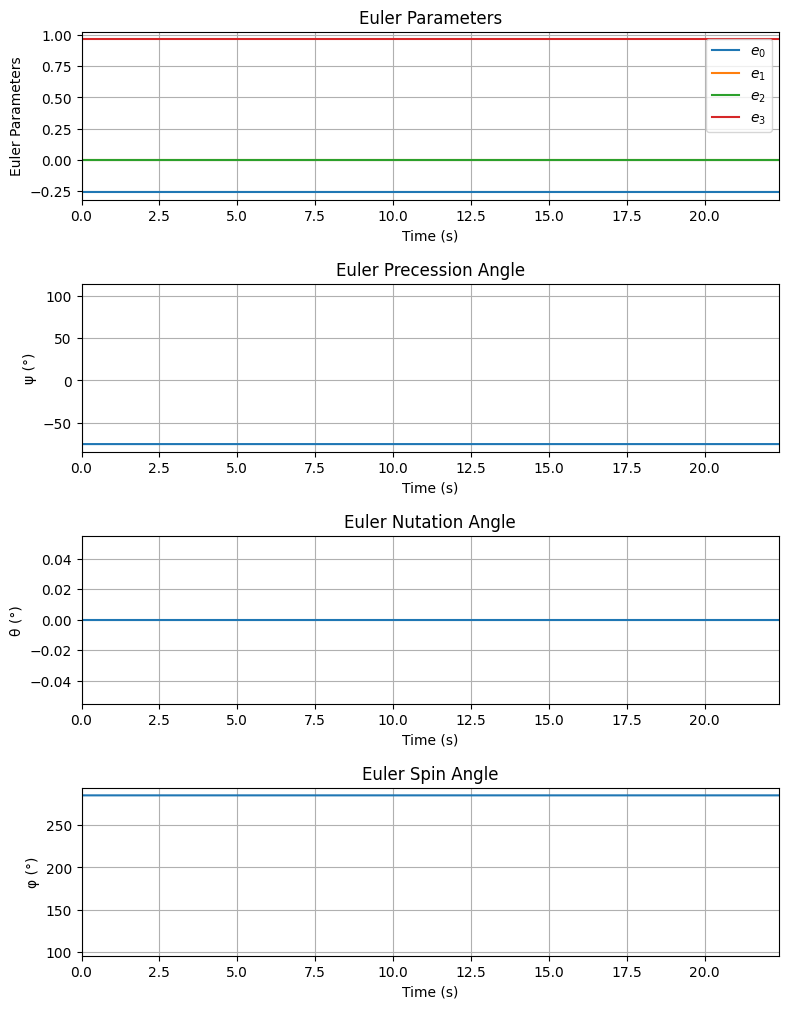



Trajectory Angular Velocity and Acceleration Plots



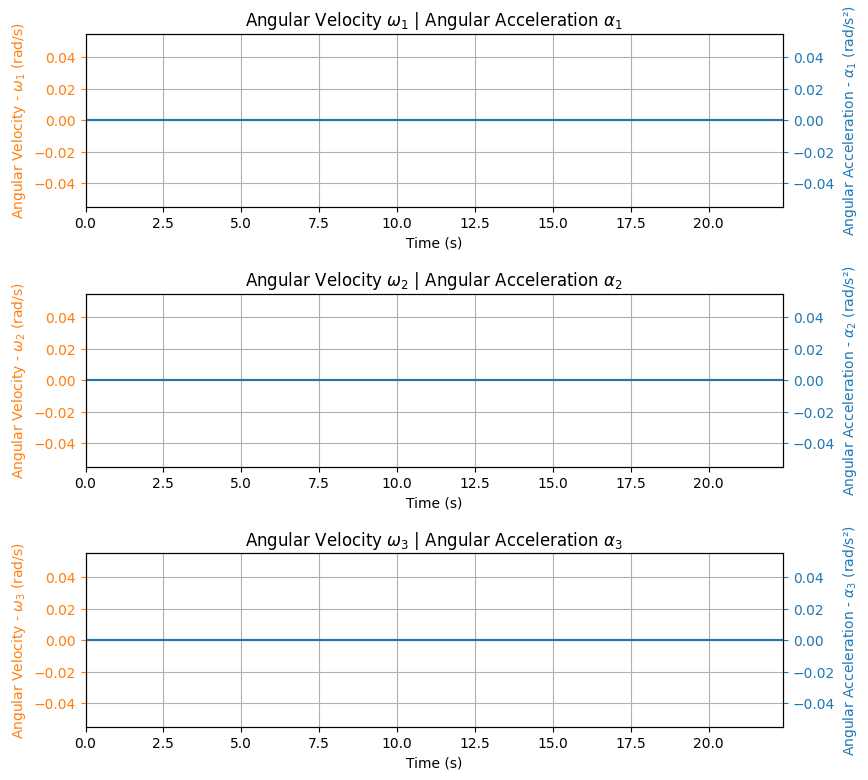



Aerodynamic Forces Plots



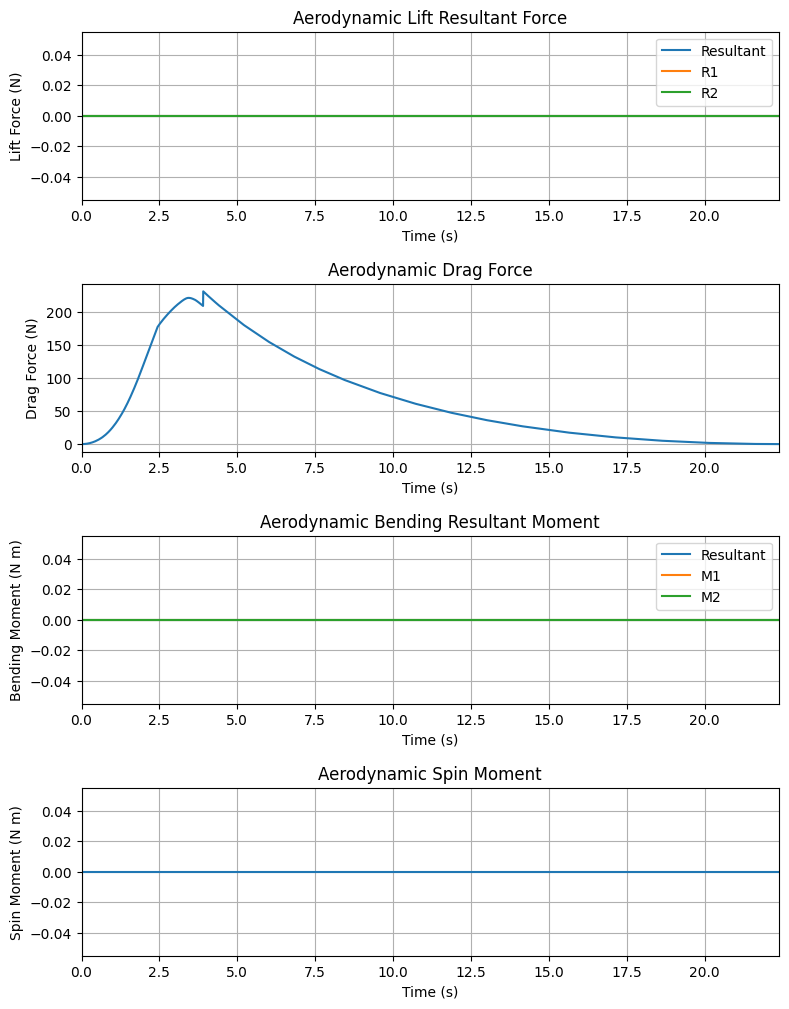



Rail Buttons Forces Plots



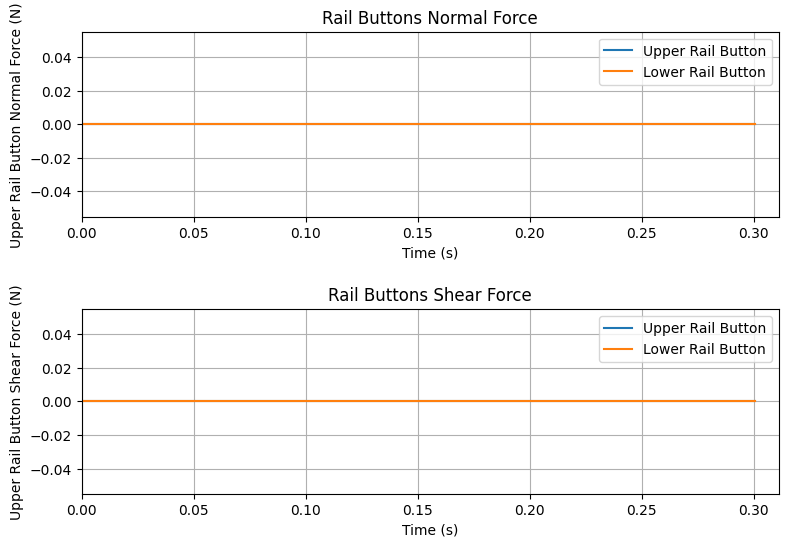



Trajectory Energy Plots



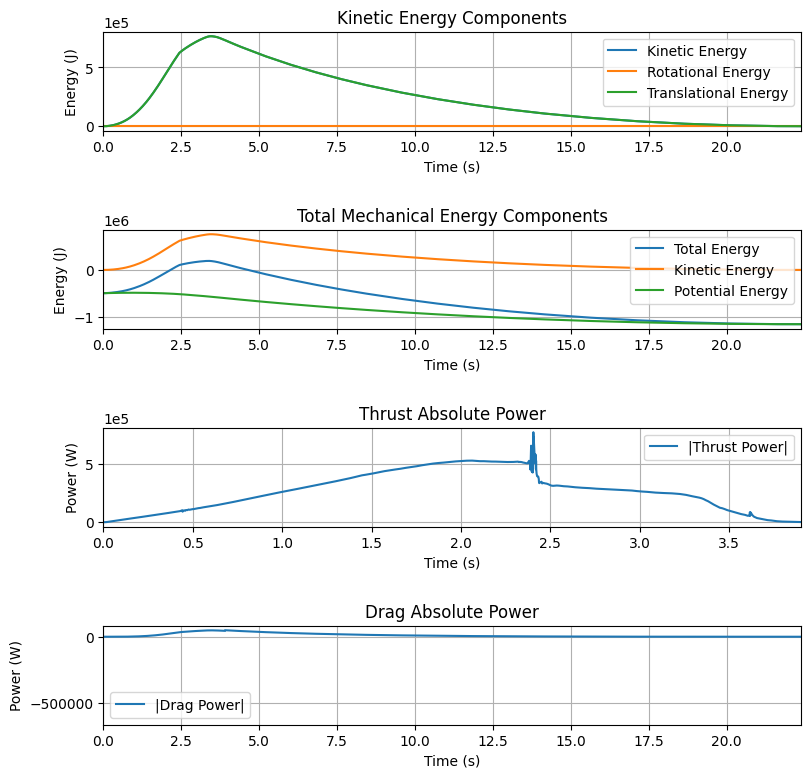



Trajectory Fluid Mechanics Plots



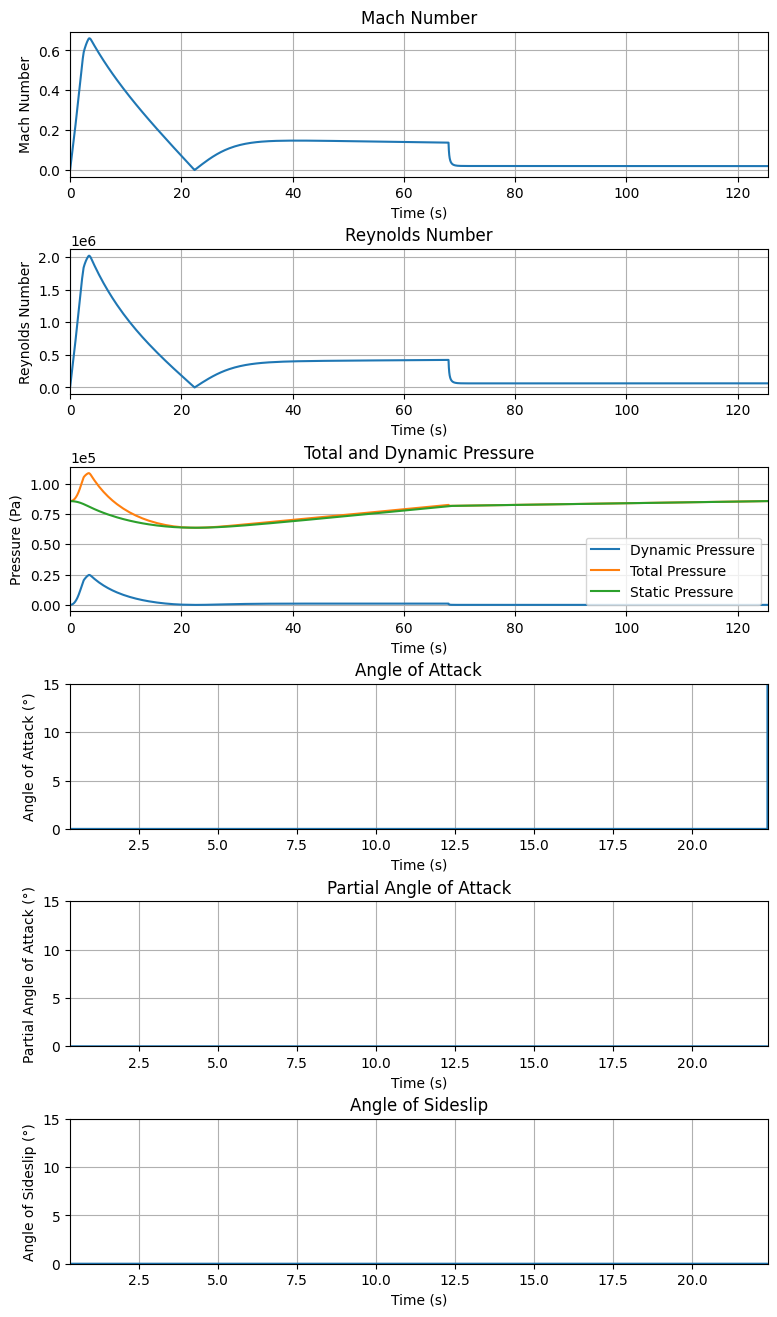



Trajectory Stability and Control Plots



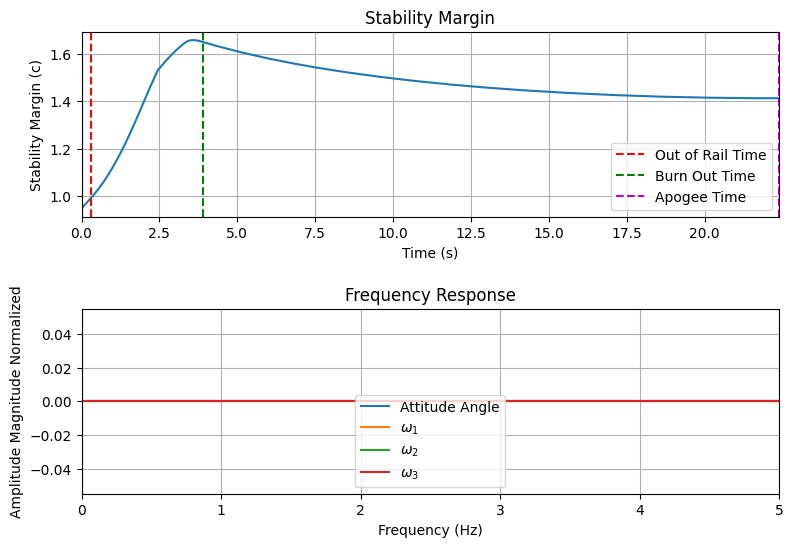



Rocket and Parachute Pressure Plots



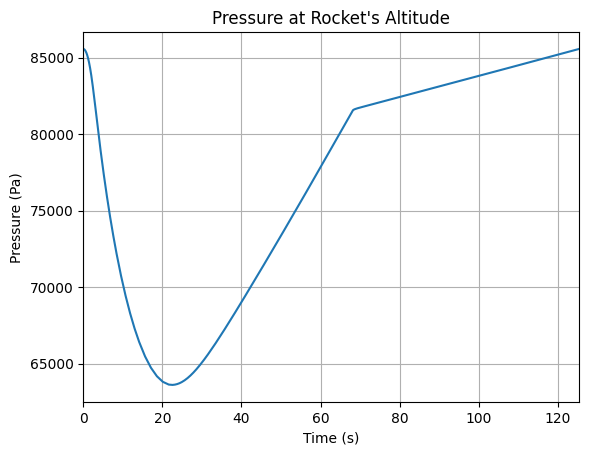


Parachute:  Main Parachute + Bag


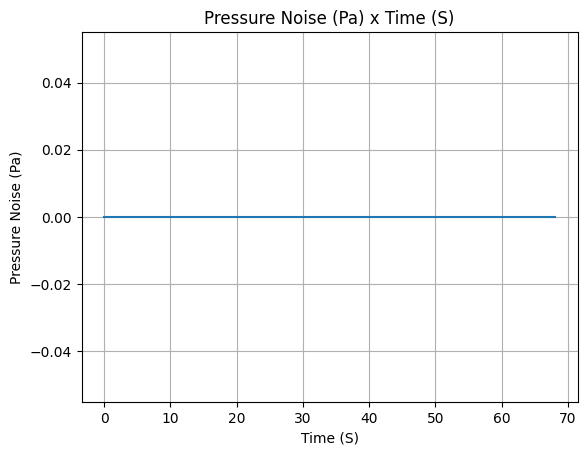

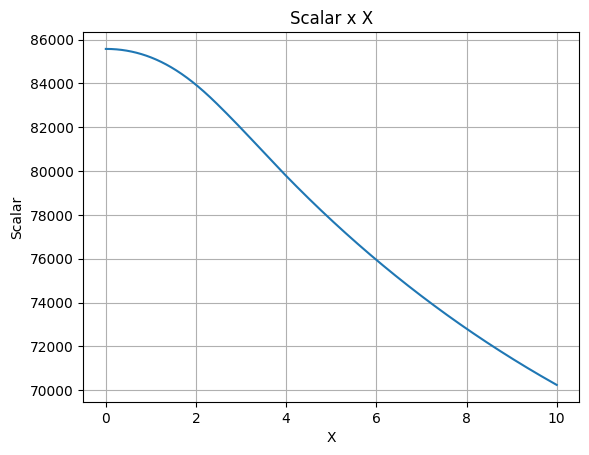

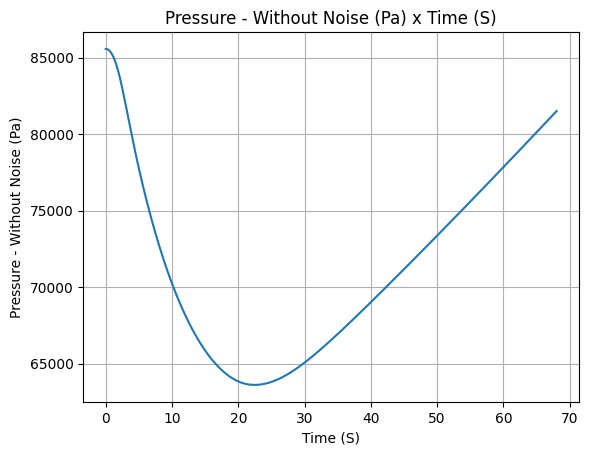


Parachute:  Drogue


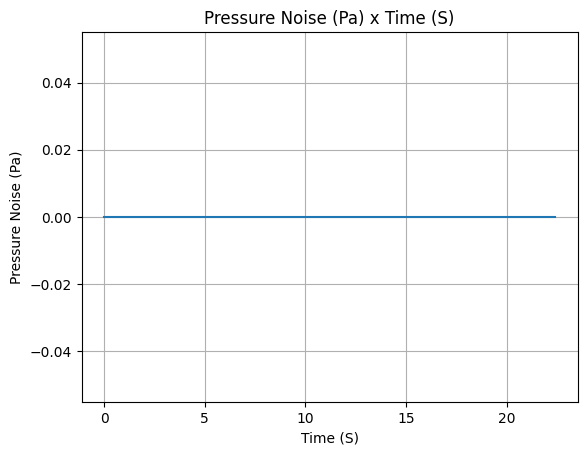

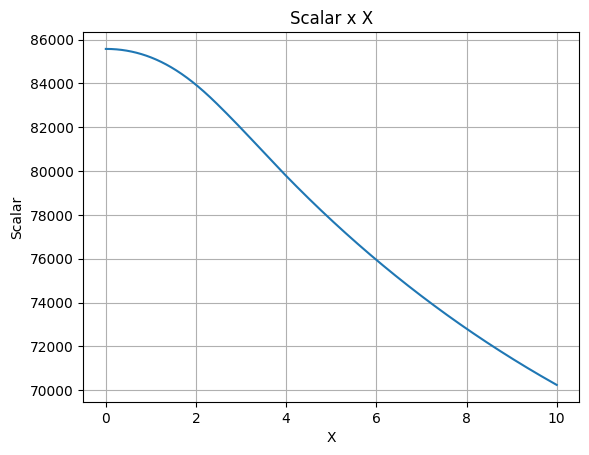

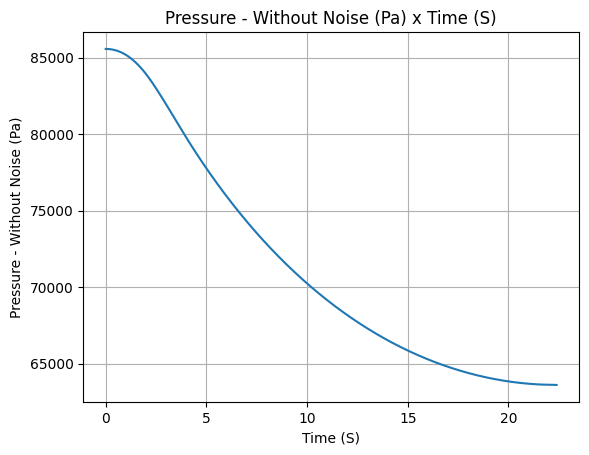

In [57]:
flight.all_info()
